# Hierarchical Soccer Model
+ intent
+ jointprob, prereqs - completed chapters 1, 2, 3 & 4, pitch level - novice, first time reader
+ session outline
+ Intro football models - league structure, poisson distributed goals
+ Model 1.1 - code straight from winbugs to python from [Bayesian hierarchical model for the prediction of football results (pdf) - Gianluca Baio1 & Marta A. Blangiardo 2010](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf) - Fail - lambda too large
+ Non-hierarchical forward simulation
    + selecting reasonable priors
+ model 1.2 - Non-hierarchical model
    + prior predictive review
+ why hierarchical (semi-pooled)?
    + start of season - promoted teams with no data
    + early season - is a team strong or has it had weak opposition
+ model 1.3 - hierarchical - fail
+ posterior geometry matters
+ model 1.4 - rebuild 1.3 with non-centred parameterization
+ model 1.5 - add coords for interpretation
+ model 1.5 appraisal to original paper results, reliability plots
+ compare model 1.2 to model 1.5
    + hierarchical model shrinkage
+ summary, repository
+ q&a

# Daniel meeting notes
+ Jointprob intro at start of talk
+ Clean Data, Notebooks, slides in jointprob repo
+ coded in pymc5

In [1]:
import os
import sys
import itertools
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine as p9
from plotnine import *

import pymc as pm
import arviz as az
import pytensor.tensor as pt
import arviz as az
from scipy.stats import poisson

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))
from notebooks.scripts.helpers import make_1x2_calib_data, format_season_df

In [2]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
SEED = 1925
LOCAL_DATA_DIR = PROJECT_DIR / 'data'
LOCAL_DATA_DIR

PosixPath('/media/david/T7/code/model-bettor/soccer-preds-001/hierarchical-soccer-model/data')

In [3]:
%load_ext watermark
%watermark --iversions

sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
pymc      : 5.7.1
pandas    : 2.0.3
pytensor  : 2.14.2
arviz     : 0.16.1
numpy     : 1.24.4
plotnine  : 0.12.2
matplotlib: 3.7.2



# Data Prep
### Italy Serie A 1992-1993

In [4]:
df_orig1 = pd.read_parquet(LOCAL_DATA_DIR / 'italy_serie-a_1991-1992.parquet')
df_orig1

Wk  Day       Date           Home        Away           Referee  \
0     1  Sun 1991-09-01         Napoli    Atalanta   Piero Ceccarini   
1     1  Sun 1991-09-01       Juventus  Fiorentina  Angelo Amendolia   
2     1  Sun 1991-09-01          Lazio       Parma   Carlo Sguizzato   
3     1  Sun 1991-09-01       Cagliari   Sampdoria    Gianni Beschin   
4     1  Sun 1991-09-01           Bari      Torino   Loris Stafoggia   
..   ..  ...        ...            ...         ...               ...   
301  34  Sun 1992-05-24           Roma        Bari  Angelo Amendolia   
302  34  Sun 1992-05-24          Parma  Fiorentina    Massimo Chiesa   
303  34  Sun 1992-05-24       Cagliari       Lazio   Graziano Cesari   
304  34  Sun 1992-05-24      Sampdoria   Cremonese    Roberto Bettin   
305  34  Sun 1992-05-24  Hellas Verona    Juventus  Paolo De Angelis   

     h_ftgoals  a_ftgoals  
0          1.0        0.0  
1          1.0        0.0  
2          1.0        1.0  
3          3.0        2.0  
4          1.0        1.0  
..         ...        ...  
301        2.0        0.0  
302        1.0        1.0  
303        0.0        1.0  
304        2.0        2.0  
305        3.0        3.0  

[306 rows x 8 columns]

### Modify column names to match original paper

In [5]:
df = df_orig1.copy()
df = format_season_df(df_orig1)
df

g      home        away  hg  ag  yg1  yg2 result
0      0    Verona        Roma  17  14  0.0  1.0   awin
1      1    Napoli    Atalanta  12   1  1.0  0.0   hwin
2      2     Lazio       Parma  10  13  1.0  1.0   draw
3      3  Juventus  Fiorentina   9   5  1.0  0.0   hwin
4      4     Inter      Foggia   8   6  1.0  1.0   draw
..   ...       ...         ...  ..  ..  ...  ...    ...
301  301     Parma  Fiorentina  13   5  1.0  1.0   draw
302  302    Napoli       Genoa  12   7  1.0  0.0   hwin
303  303     Inter    Atalanta   8   1  0.0  0.0   draw
304  304    Foggia       Milan   6  11  2.0  8.0   awin
305  305  Cagliari       Lazio   3  10  0.0  1.0   awin

[306 rows x 8 columns]

# Model 1.1
+ First model as described in the paper - [Bayesian hierarchical model for the prediction of football results - section 2 - Gianluca Baio1 & Marta A. Blangiardo 2010](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf)
+ Code directly translated from original winbugs code to pymc
+ Variables renamed to correspond to naming in original paper

In [6]:
n_teams = df['hg'].nunique()
home_idx = df['hg'].values
away_idx = df['ag'].values
home_goals = df['yg1'].values
away_goals = df['yg2'].values
print(f'n_teams: {n_teams}')
print(f'home team indices (home_idx): {home_idx[0:5]}...')
print(f'away team indices (away_idx): {away_idx[0:5]}...')
print(f'home goals : {home_goals[0:5]}...')
print(f'away goals: {away_goals[0:5]}...')
tau = 0.0001
sigma = np.sqrt(1.0/tau)
print(f'sigma: {sigma}')

n_teams: 18
home team indices (home_idx): [17 12 10  9  8]...
away team indices (away_idx): [14  1 13  5  6]...
home goals : [0. 1. 1. 1. 1.]...
away goals: [1. 0. 1. 0. 1.]...
sigma: 100.0


In [7]:
with pm.Model() as model1_1:
    # hyper-priors
    mu_att = pm.Normal('mu_att', mu=0, sigma=sigma)
    tau_att = pm.Gamma('tau_att', 0.01, 0.01)    
    mu_def = pm.Normal('mu_def', mu=0, sigma=sigma)
    tau_def = pm.Gamma('tau_def', 0.01, 0.01)

    # priors
    home = pm.Normal("home", mu=0, sigma=sigma)
    att_t = pm.Normal('att_t', mu=mu_att, tau=tau_att, shape=n_teams)
    def_t = pm.Normal('def_t', mu=mu_def, tau=tau_def, shape=n_teams)

    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
    away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

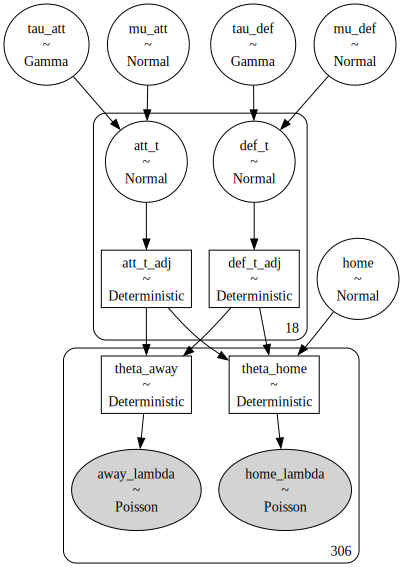

In [8]:
pm.model_to_graphviz(model1_1)

In [9]:
# Crashes pymc
# with model1_1:
#     idata1_1 = pm.sample_prior_predictive()

In [10]:
with model1_1:
    idata1_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_att, tau_att, mu_def, tau_def, home, att_t, def_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 193 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1527 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [11]:
idata1_1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

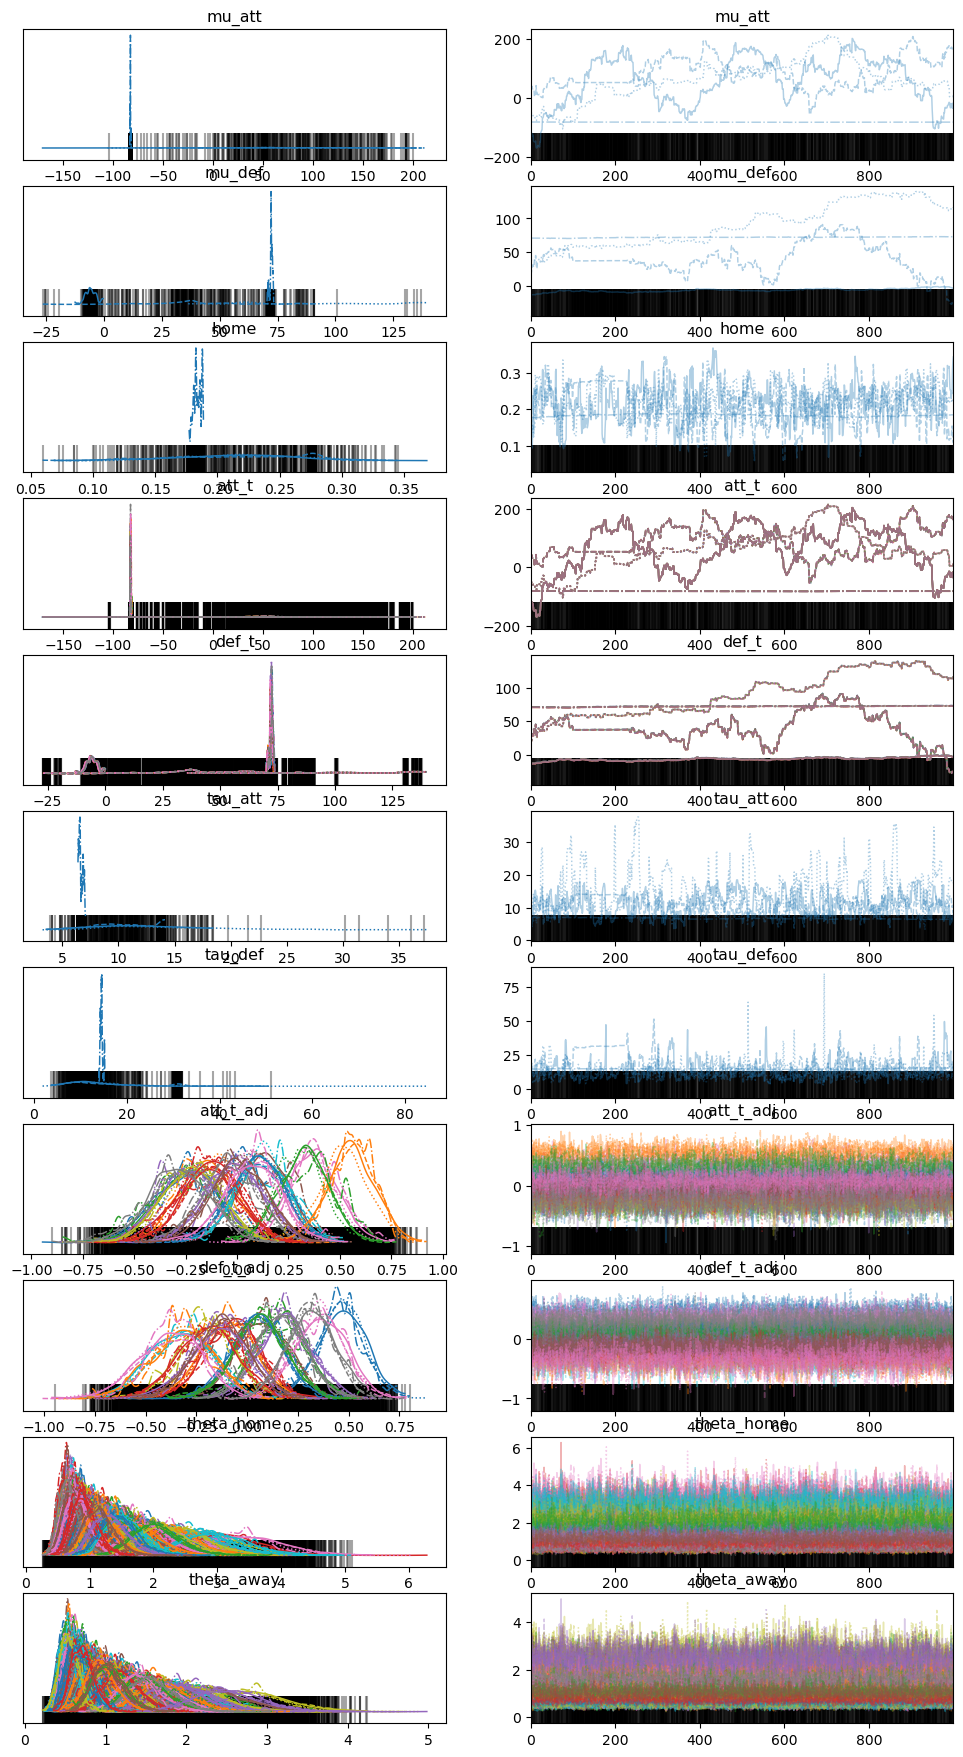

In [12]:
az.plot_trace(idata1_1);

# League Football
+ Serie-a 1992-1993 season had 18 teams.
+ In a season - every team plays every other team in the league, once at home and once away.
+ This means the 1992-1993 season comprised 18 x 17 = 306 matches.
+ Every game can result in one of 3 outcomes - a home win, a draw or an away win.
+ At the end of every season 3 teams are relegated from the league, and 3 new teams are promoted into the league.
+ Football is a low scoring game, with a reasonably high degree of randomness. The distribution of goals can be modeled by a poisson distribution - See [Predicting Football Results With Statistical Modelling](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)

# Forward Simulation
### Key Inputs
+ If we ignore the hierachical structure we have 3 key inputs
    + home advantage `home` (common across all teams)
    + attack ability `att_t` - The attacking strength of each team
    + defence ability `def_t` - The defending capability of each team
### Zero sum constraint   
+ The attack and defence abilities are adjusted/constrained to sum to zero. This is done by subtracting the mean attack ability (calculated across all teams) from the attack ability of each team. Same for defence.
### Link function and mean score calculation 
+ Every match in the fixture list has a two "expected goals" numbers - one for the home team and one for the away team. 
+ These are calculated using the adjusted attack and defence abilities which are fed into 2 equations for every match in the fixture list:
    + theta_home_team = exponential(home advantage + adj_attack[home team] + adj_defence[away_team])
    + theta_away_team = exponential(adj_attack[away_team] + adj_defence[home_team]
### Goal scoring data
+ We now have an "expected goals" number for the home team and the away team for every fixture. This number is modeled as the mean of a poisson distribution, so for each match in the fixture list, we can sample from the relevant poisson distributions to get a score.
### Approach
+ Build a forward model - try various inputs for home advantage, attack ability and defence ability - and get a feel for how well the model output matches the scores we expect to see in a top football league.

In [13]:
def simulate_season(home, fixtures):    
    fixtures['home_team_raw'] = home + fixtures['home_team_att'] + fixtures['away_team_def']
    fixtures['away_team_raw'] = fixtures['away_team_att'] + fixtures['home_team_def']
    fixtures['theta_home_team'] = np.exp(fixtures['home_team_raw'])
    fixtures['theta_away_team'] = np.exp(fixtures['away_team_raw'])

    fixtures['home_team_goals'] = np.random.poisson(lam=fixtures['theta_home_team'])
    fixtures['away_team_goals'] = np.random.poisson(lam=fixtures['theta_away_team'])

    return fixtures   

def apply_zero_sum_constraint(att_t, def_t):
    att_t_adj = att_t - np.mean(att_t)
    def_t_adj = def_t - np.mean(def_t)
    
    return att_t_adj, def_t_adj
    
teams = [0, 1, 2]
fixtures = np.array(list(zip(*list(itertools.permutations(teams, 2))))).T
df_fixtures = pd.DataFrame(fixtures, columns=['home_team', 'away_team'])
df_fixtures

home_team  away_team
0          0          1
1          0          2
2          1          0
3          1          2
4          2          0
5          2          1

In [14]:
att_t = [1, 2, 3]
def_t = [1, 2, 3]

att_t_adj, def_t_adj = apply_zero_sum_constraint(att_t, def_t)
att_t_adj, def_t_adj

(array([-1.,  0.,  1.]), array([-1.,  0.,  1.]))

In [15]:
df_fixtures['home_team_att'] = df_fixtures['home_team'].map(lambda x: att_t_adj[x])
df_fixtures

home_team  away_team  home_team_att
0          0          1           -1.0
1          0          2           -1.0
2          1          0            0.0
3          1          2            0.0
4          2          0            1.0
5          2          1            1.0

In [16]:
df_fixtures['home_team_def'] = df_fixtures['home_team'].map(lambda x: def_t_adj[x])
df_fixtures['away_team_att'] = df_fixtures['away_team'].map(lambda x: att_t_adj[x])
df_fixtures['away_team_def'] = df_fixtures['away_team'].map(lambda x: def_t_adj[x])
df_fixtures

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0          0          1           -1.0           -1.0            0.0   
1          0          2           -1.0           -1.0            1.0   
2          1          0            0.0            0.0           -1.0   
3          1          2            0.0            0.0            1.0   
4          2          0            1.0            1.0           -1.0   
5          2          1            1.0            1.0            0.0   

   away_team_def  
0            0.0  
1            1.0  
2           -1.0  
3            1.0  
4           -1.0  
5            0.0

In [17]:
home = 1
results = simulate_season(home, df_fixtures)
results

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0          0          1           -1.0           -1.0            0.0   
1          0          2           -1.0           -1.0            1.0   
2          1          0            0.0            0.0           -1.0   
3          1          2            0.0            0.0            1.0   
4          2          0            1.0            1.0           -1.0   
5          2          1            1.0            1.0            0.0   

   away_team_def  home_team_raw  away_team_raw  theta_home_team  \
0            0.0            0.0           -1.0         1.000000   
1            1.0            1.0            0.0         2.718282   
2           -1.0            0.0           -1.0         1.000000   
3            1.0            2.0            1.0         7.389056   
4           -1.0            1.0            0.0         2.718282   
5            0.0            2.0            1.0         7.389056   

   theta_away_team  home_team_goals  away_team_goals  
0         0.367879                1                0  
1         1.000000                1                0  
2         0.367879                2                0  
3         2.718282                8                0  
4         1.000000                2                2  
5         2.718282                4                4

In [18]:
def forward_model(home, att_t, def_t, n_teams):
    teams = np.arange(n_teams)
    fixtures = np.array(list(zip(*list(itertools.permutations(teams, 2))))).T
    df_fixtures = pd.DataFrame(fixtures, columns=['home_team', 'away_team'])

    att_t_adj, def_t_adj = apply_zero_sum_constraint(att_t, def_t)

    df_fixtures['home_team_att'] = df_fixtures['home_team'].map(lambda x: att_t_adj[x])
    df_fixtures['home_team_def'] = df_fixtures['home_team'].map(lambda x: def_t_adj[x])
    df_fixtures['away_team_att'] = df_fixtures['away_team'].map(lambda x: att_t_adj[x])
    df_fixtures['away_team_def'] = df_fixtures['away_team'].map(lambda x: def_t_adj[x])

    return simulate_season(home, df_fixtures)

In [19]:
n_teams = 18
att_t = np.random.uniform(0, 20, size=n_teams)
def_t = np.random.uniform(0, 20, size=n_teams)
home = 10
season_sim = forward_model(home, att_t, def_t, n_teams)
season_sim

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0            0          1       0.474202      -7.966395       1.829518   
1            0          2       0.474202      -7.966395      -2.864550   
2            0          3       0.474202      -7.966395       6.862273   
3            0          4       0.474202      -7.966395      -8.586759   
4            0          5       0.474202      -7.966395       1.555384   
..         ...        ...            ...            ...            ...   
301         17         12      -3.522086      -7.778567      -0.434440   
302         17         13      -3.522086      -7.778567      -4.361429   
303         17         14      -3.522086      -7.778567      -2.961929   
304         17         15      -3.522086      -7.778567       7.218988   
305         17         16      -3.522086      -7.778567       1.097018   

     away_team_def  home_team_raw  away_team_raw  theta_home_team  \
0         2.411129      12.885330      -6.136877     3.944826e+05   
1        -6.179085       4.295117     -10.830945     7.334076e+01   
2        -1.324364       9.149837      -1.104123     9.412908e+03   
3         0.290850      10.765051     -16.553155     4.733718e+04   
4         0.334210      10.808411      -6.411012     4.943487e+04   
..             ...            ...            ...              ...   
301       7.967508      14.445422      -8.213007     1.877445e+06   
302       4.640205      11.118119     -12.139996     6.738104e+04   
303       5.749189      12.227103     -10.740496     2.042506e+05   
304      -4.000666       2.477248      -0.559579     1.190845e+01   
305       2.338321       8.816235      -6.681549     6.742830e+03   

     theta_away_team  home_team_goals  away_team_goals  
0       2.161663e-03           395902                0  
1       1.977791e-05               68                0  
2       3.315015e-01             9351                0  
3       6.472265e-08            47450                0  
4       1.643361e-03            49719                0  
..               ...              ...              ...  
301     2.711042e-04          1876290                0  
302     5.341542e-06            67051                0  
303     2.165019e-05           204574                0  
304     5.714497e-01               10                0  
305     1.253834e-03             6646                0  

[306 rows x 12 columns]

In [20]:
n_teams = 18
att_t = np.random.uniform(0, 3, size=n_teams)
def_t = np.random.uniform(-3, 0, size=n_teams)
home = 0.5
season_sim = forward_model(home, att_t, def_t, n_teams)
season_sim

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0            0          1      -0.041181      -1.328071      -1.267744   
1            0          2      -0.041181      -1.328071      -0.514000   
2            0          3      -0.041181      -1.328071      -0.400675   
3            0          4      -0.041181      -1.328071       0.122705   
4            0          5      -0.041181      -1.328071       0.801578   
..         ...        ...            ...            ...            ...   
301         17         12       0.190203      -0.466303       0.382041   
302         17         13       0.190203      -0.466303       0.382800   
303         17         14       0.190203      -0.466303      -0.042061   
304         17         15       0.190203      -0.466303       0.166536   
305         17         16       0.190203      -0.466303       0.520922   

     away_team_def  home_team_raw  away_team_raw  theta_home_team  \
0        -0.261319       0.197500      -2.595815         1.218353   
1        -1.184954      -0.726135      -1.842071         0.483775   
2        -0.399845       0.058974      -1.728746         1.060748   
3         0.656935       1.115754      -1.205366         3.051870   
4         0.331336       0.790155      -0.526493         2.203739   
..             ...            ...            ...              ...   
301       1.034971       1.725175      -0.084262         5.613502   
302      -0.711154      -0.020951      -0.083503         0.979267   
303       0.705002       1.395206      -0.508364         4.035805   
304       1.260399       1.950603      -0.299767         7.032926   
305      -0.196122       0.494081       0.054619         1.638992   

     theta_away_team  home_team_goals  away_team_goals  
0           0.074585                0                0  
1           0.158489                0                0  
2           0.177507                4                1  
3           0.299582                1                0  
4           0.590673                3                1  
..               ...              ...              ...  
301         0.919191                5                0  
302         0.919889                0                1  
303         0.601479                4                0  
304         0.740991               12                0  
305         1.056138                1                0  

[306 rows x 12 columns]

# Model 1.2
+ Priors adjusted based on simulation
+ Unpooled, non-hierarchical model
+ variable names changed for better intuition

In [21]:
with pm.Model() as model1_2:
    # home advantage
    home = pm.Normal("home", mu=0.5, sigma=0.5/3)

    # priors
    att_t = pm.Normal('att_t', mu=1.5, sigma=0.5, shape=n_teams)
    def_t = pm.Normal('def_t', mu=-1.5, sigma=0.5, shape=n_teams)

    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_goalsl = pm.Poisson('home_goalsl', mu=theta_home, observed=home_goals)
    away_goalsl = pm.Poisson('away_goalsl', mu=theta_away, observed=away_goals)

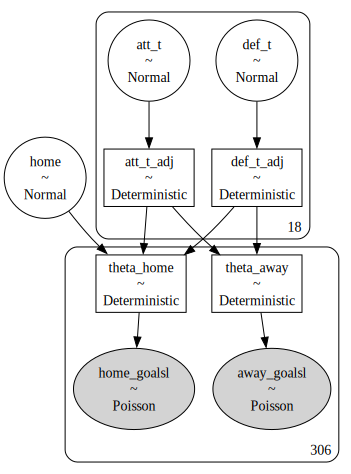

In [22]:
pm.model_to_graphviz(model1_2)

## Model 1.2 Prior Predictive Checks

In [23]:
with model1_2:
    idata1_2 = pm.sample_prior_predictive()

Sampling: [att_t, away_goalsl, def_t, home, home_goalsl]


In [24]:
idata1_2

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [25]:
az.summary(idata1_2.prior_predictive)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
home_goalsl[0]    1.976  2.042     0.0      6.0      0.094    0.066     473.0   
home_goalsl[1]    2.374  2.550     0.0      6.0      0.118    0.084     516.0   
home_goalsl[2]    2.104  2.165     0.0      6.0      0.103    0.073     418.0   
home_goalsl[3]    2.200  2.249     0.0      6.0      0.104    0.075     479.0   
home_goalsl[4]    2.040  2.100     0.0      6.0      0.094    0.067     474.0   
...                 ...    ...     ...      ...        ...      ...       ...   
away_goalsl[301]  1.366  1.570     0.0      4.0      0.072    0.054     491.0   
away_goalsl[302]  1.142  1.359     0.0      3.0      0.067    0.054     446.0   
away_goalsl[303]  1.174  1.406     0.0      4.0      0.061    0.043     487.0   
away_goalsl[304]  1.324  1.563     0.0      4.0      0.068    0.048     516.0   
away_goalsl[305]  1.212  1.434     0.0      4.0      0.075    0.053     352.0   

                  ess_tail  r_hat  
home_goalsl[0]       462.0    NaN  
home_goalsl[1]       412.0    NaN  
home_goalsl[2]       438.0    NaN  
home_goalsl[3]       450.0    NaN  
home_goalsl[4]       500.0    NaN  
...                    ...    ...  
away_goalsl[301]     474.0    NaN  
away_goalsl[302]     329.0    NaN  
away_goalsl[303]     441.0    NaN  
away_goalsl[304]     506.0    NaN  
away_goalsl[305]     405.0    NaN  

[612 rows x 9 columns]

In [26]:
with model1_2:
    idata1_2.extend(pm.sample())
    # idata1_2.extend(pm.sample(tune=2000, target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, att_t, def_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [27]:
idata1_2

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

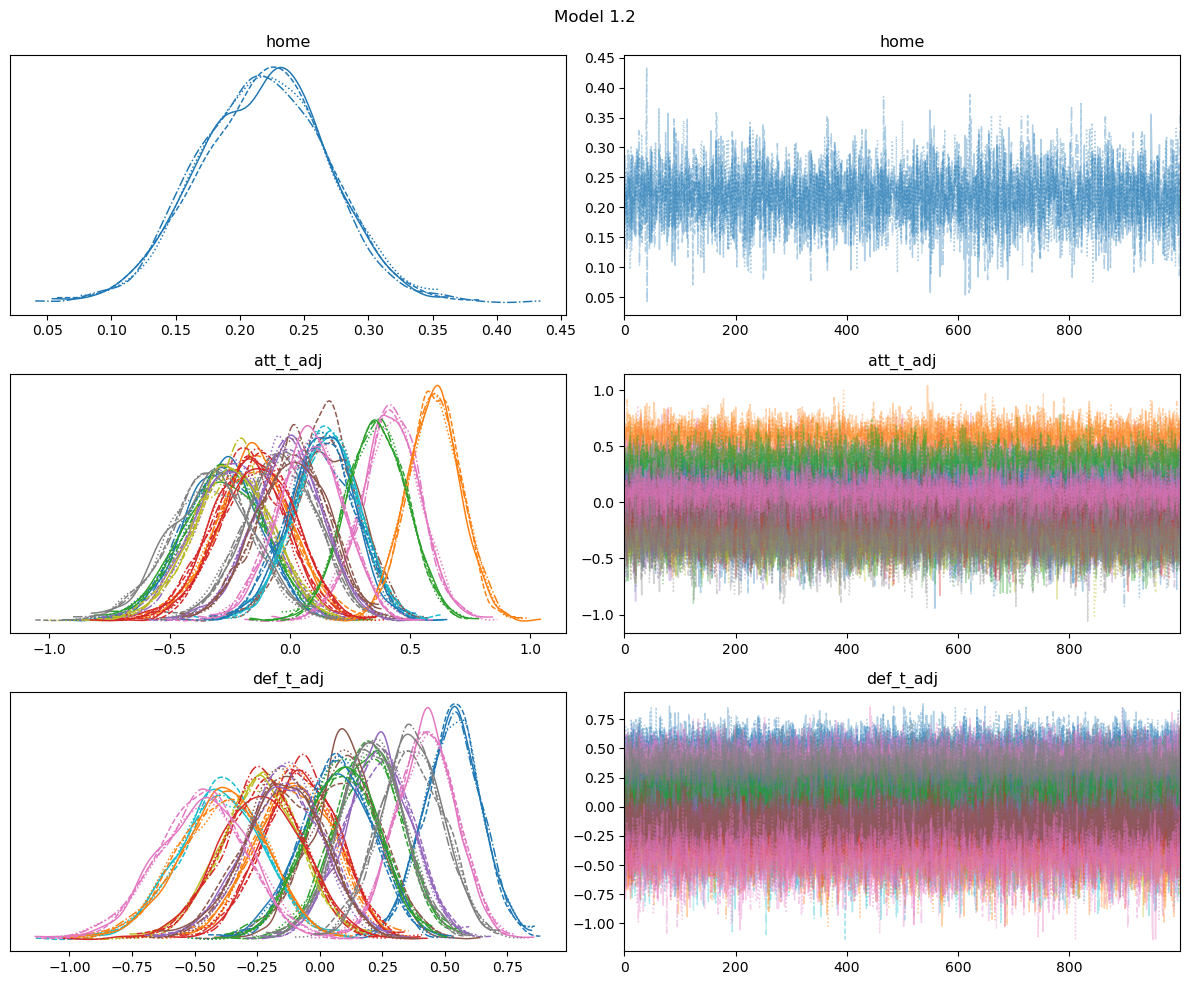

In [28]:
az.plot_trace(idata1_2, var_names=['^home$', 't_adj'], filter_vars='regex', figsize=(12, 10))
plt.suptitle('Model 1.2')
plt.tight_layout()
plt.show();

In [29]:
az.summary(idata1_2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
home             0.218  0.049   0.129    0.311      0.001    0.000    7066.0   
att_t[0]         1.224  0.203   0.829    1.592      0.005    0.003    1771.0   
att_t[1]         1.353  0.202   0.954    1.725      0.005    0.004    1671.0   
att_t[2]         1.231  0.210   0.834    1.615      0.005    0.003    1823.0   
att_t[3]         1.326  0.198   0.955    1.709      0.005    0.003    1660.0   
...                ...    ...     ...      ...        ...      ...       ...   
theta_away[301]  0.940  0.200   0.575    1.318      0.002    0.002   10868.0   
theta_away[302]  1.070  0.222   0.685    1.506      0.002    0.002   12904.0   
theta_away[303]  0.694  0.159   0.404    0.997      0.002    0.001   10122.0   
theta_away[304]  2.818  0.466   1.942    3.668      0.005    0.004    9316.0   
theta_away[305]  1.071  0.215   0.679    1.463      0.002    0.002    9443.0   

                 ess_tail  r_hat  
home               3182.0    1.0  
att_t[0]           2051.0    1.0  
att_t[1]           2273.0    1.0  
att_t[2]           2475.0    1.0  
att_t[3]           2610.0    1.0  
...                   ...    ...  
theta_away[301]    2779.0    1.0  
theta_away[302]    3009.0    1.0  
theta_away[303]    2598.0    1.0  
theta_away[304]    2406.0    1.0  
theta_away[305]    3129.0    1.0  

[685 rows x 9 columns]

## TODO - model 1.2
+ Plot of attack strength vs defence strength for named teams
+ insert team names
+ 
---

# Why Hierarchical ?
TODO

# Model 1.3
+ Hierarchical Model
+ Priors narrowed based on learning from non-hierarchical model
+ Prior distributions changed to more common distributions

In [30]:
with pm.Model() as model2:
    # home advantage
    home = pm.Normal("home", mu=0.5, sigma=0.5/3)

    # hyper-priors
    mu_att = pm.Normal('mu_att', mu=1.5, sigma=0.5)
    sigma_att = pm.HalfNormal('sigma_att', sigma=1)    
    mu_def = pm.Normal('mu_def', mu=-1.5, sigma=0.5)
    sigma_def = pm.HalfNormal('sigma_def', sigma=1)

    # priors
    att_t = pm.Normal('att_t', mu=mu_att, sigma=sigma_att, shape=n_teams)
    def_t = pm.Normal('def_t', mu=mu_def, sigma=sigma_def, shape=n_teams)

    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
    away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

In [31]:
# TODO - show problems

# Model 3
+ Non-centred parametrization

In [32]:
with pm.Model() as model3:
    # home advantage
    home = pm.Normal("home", mu=0.5, sigma=0.25)

    # hyper-priors
    mu_att_ = pm.Normal('mu_att', mu=0, sigma=0.5)
    sigma_att = pm.HalfNormal('sigma_att', sigma=0.333)    
    mu_def_ = pm.Normal('mu_def', mu=0, sigma=0.5)
    sigma_def = pm.HalfNormal('sigma_def', sigma=0.333)

    # offsets ?
    att_t_ = pm.Normal("att_t_", 0, 1, shape=n_teams)
    def_t_ = pm.Normal('def_t_', 0, 1, shape=n_teams)

    # priors    
    att_t = pm.Deterministic('att_t', mu_att_ + att_t_ * sigma_att)
    def_t = pm.Deterministic('def_t', mu_def_ + def_t_ * sigma_def)

    
    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
    away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

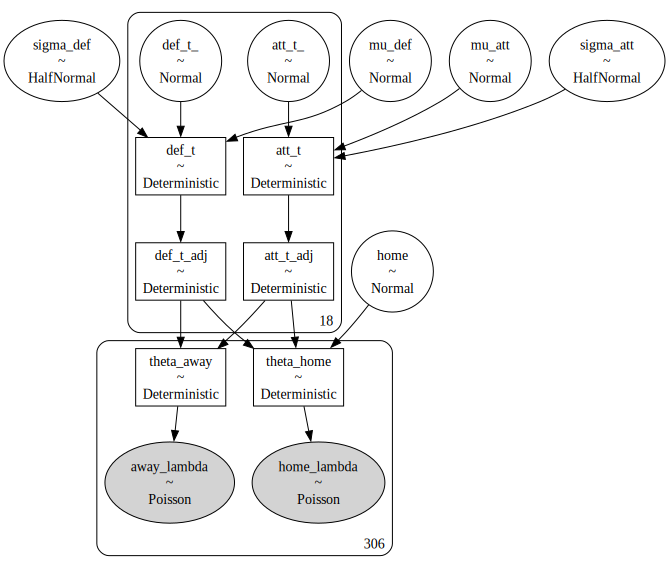

In [33]:
pm.model_to_graphviz(model3)

In [34]:
with model3:
    idata = pm.sample_prior_predictive()

Sampling: [att_t_, away_lambda, def_t_, home, home_lambda, mu_att, mu_def, sigma_att, sigma_def]


In [35]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [36]:
with model3:
    idata = pm.sample(4000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, mu_att, sigma_att, mu_def, sigma_def, att_t_, def_t_]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 15 seconds.


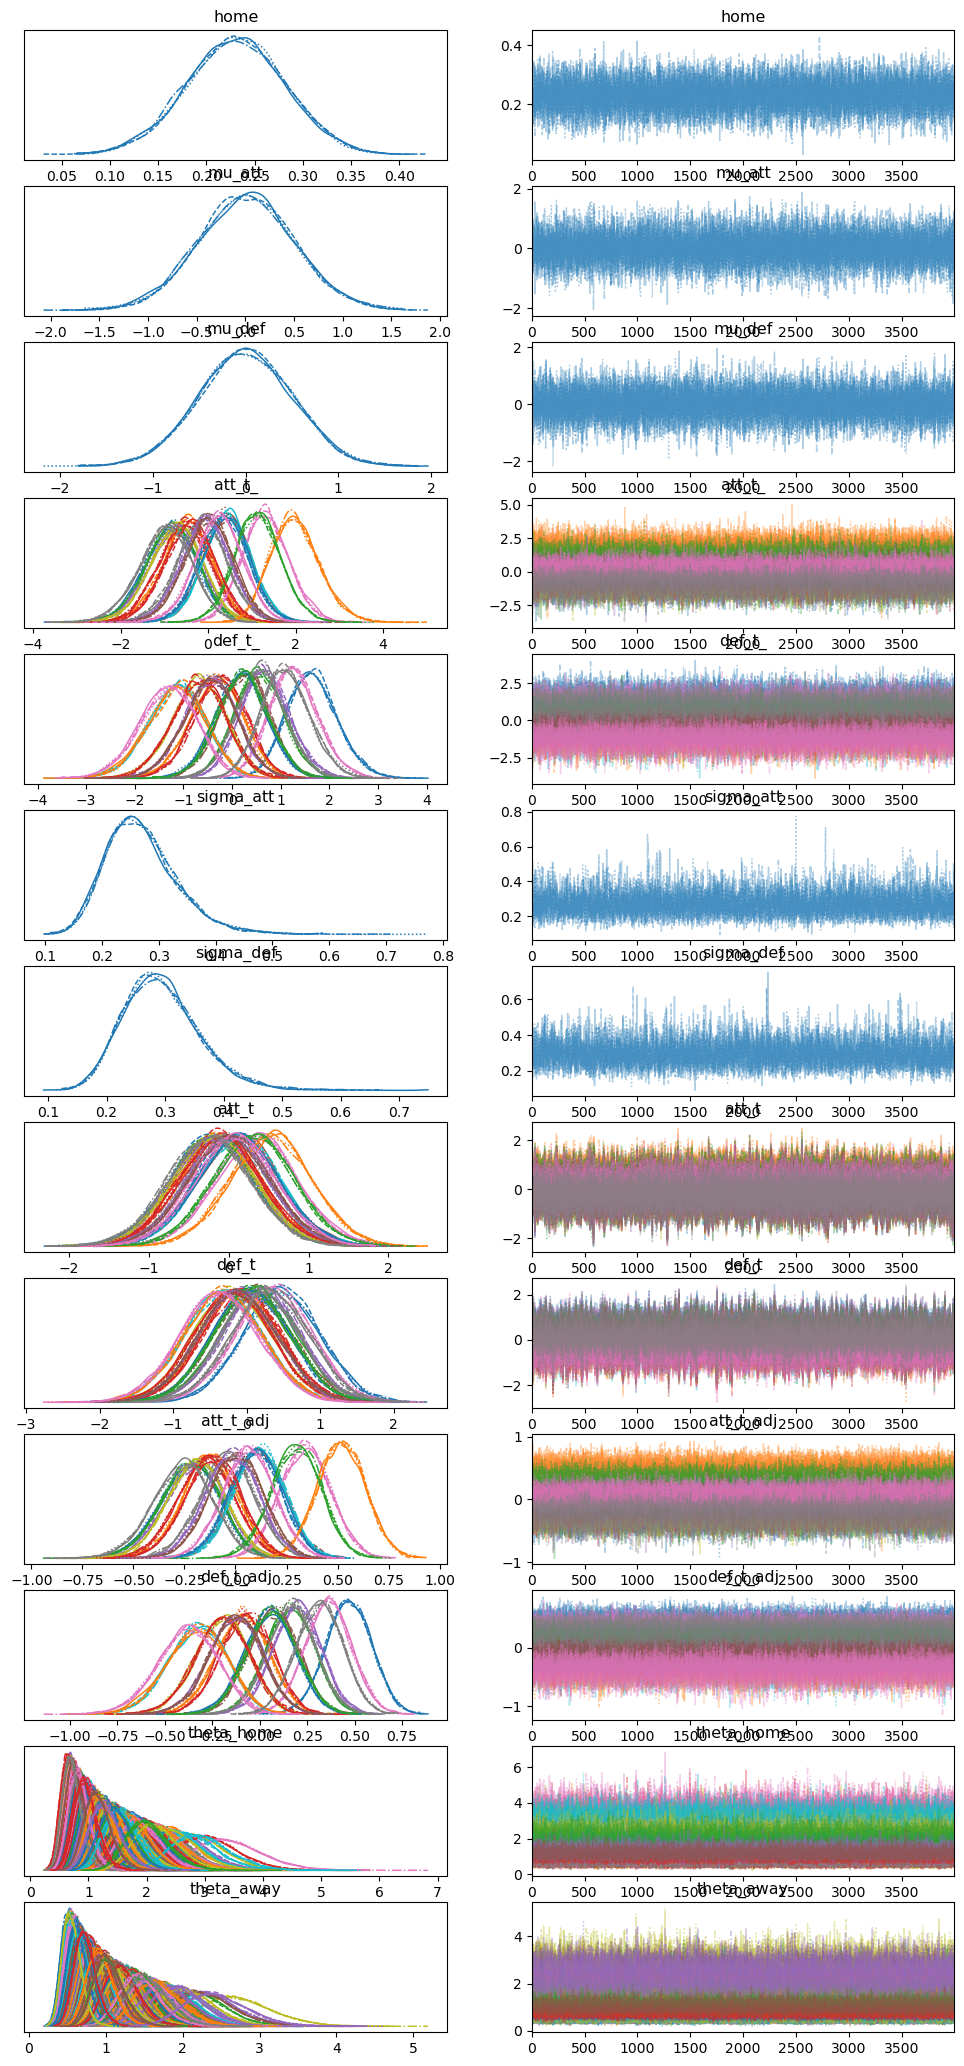

In [37]:
az.plot_trace(idata);

# Model 4
+ Non-centred parametrization
+ priors opened up
+ Add coords for easier interpretation

In [38]:
# TODO COORDS

In [39]:
with pm.Model() as model4:
    # home advantage
    home = pm.Normal("home", mu=0.0, sigma=1.0)

    # hyper-priors
    mu_att_ = pm.Normal('mu_att', mu=0, sigma=1.0)
    sigma_att = pm.HalfNormal('sigma_att', sigma=1.0)    
    mu_def_ = pm.Normal('mu_def', mu=0, sigma=1.0)
    sigma_def = pm.HalfNormal('sigma_def', sigma=1.0)

    att_t_ = pm.Normal("att_t_", 0, 1, shape=n_teams)
    def_t_ = pm.Normal('def_t_', 0,1, shape=n_teams)

    # priors    
    att_t = pm.Deterministic('att_t', mu_att_ + att_t_ * sigma_att)
    def_t = pm.Deterministic('def_t', mu_def_ + def_t_ * sigma_def)
    
    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
    away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

In [40]:
with model4:
    idata = pm.sample_prior_predictive()

Sampling: [att_t_, away_lambda, def_t_, home, home_lambda, mu_att, mu_def, sigma_att, sigma_def]


In [41]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [42]:
with model4:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, mu_att, sigma_att, mu_def, sigma_def, att_t_, def_t_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


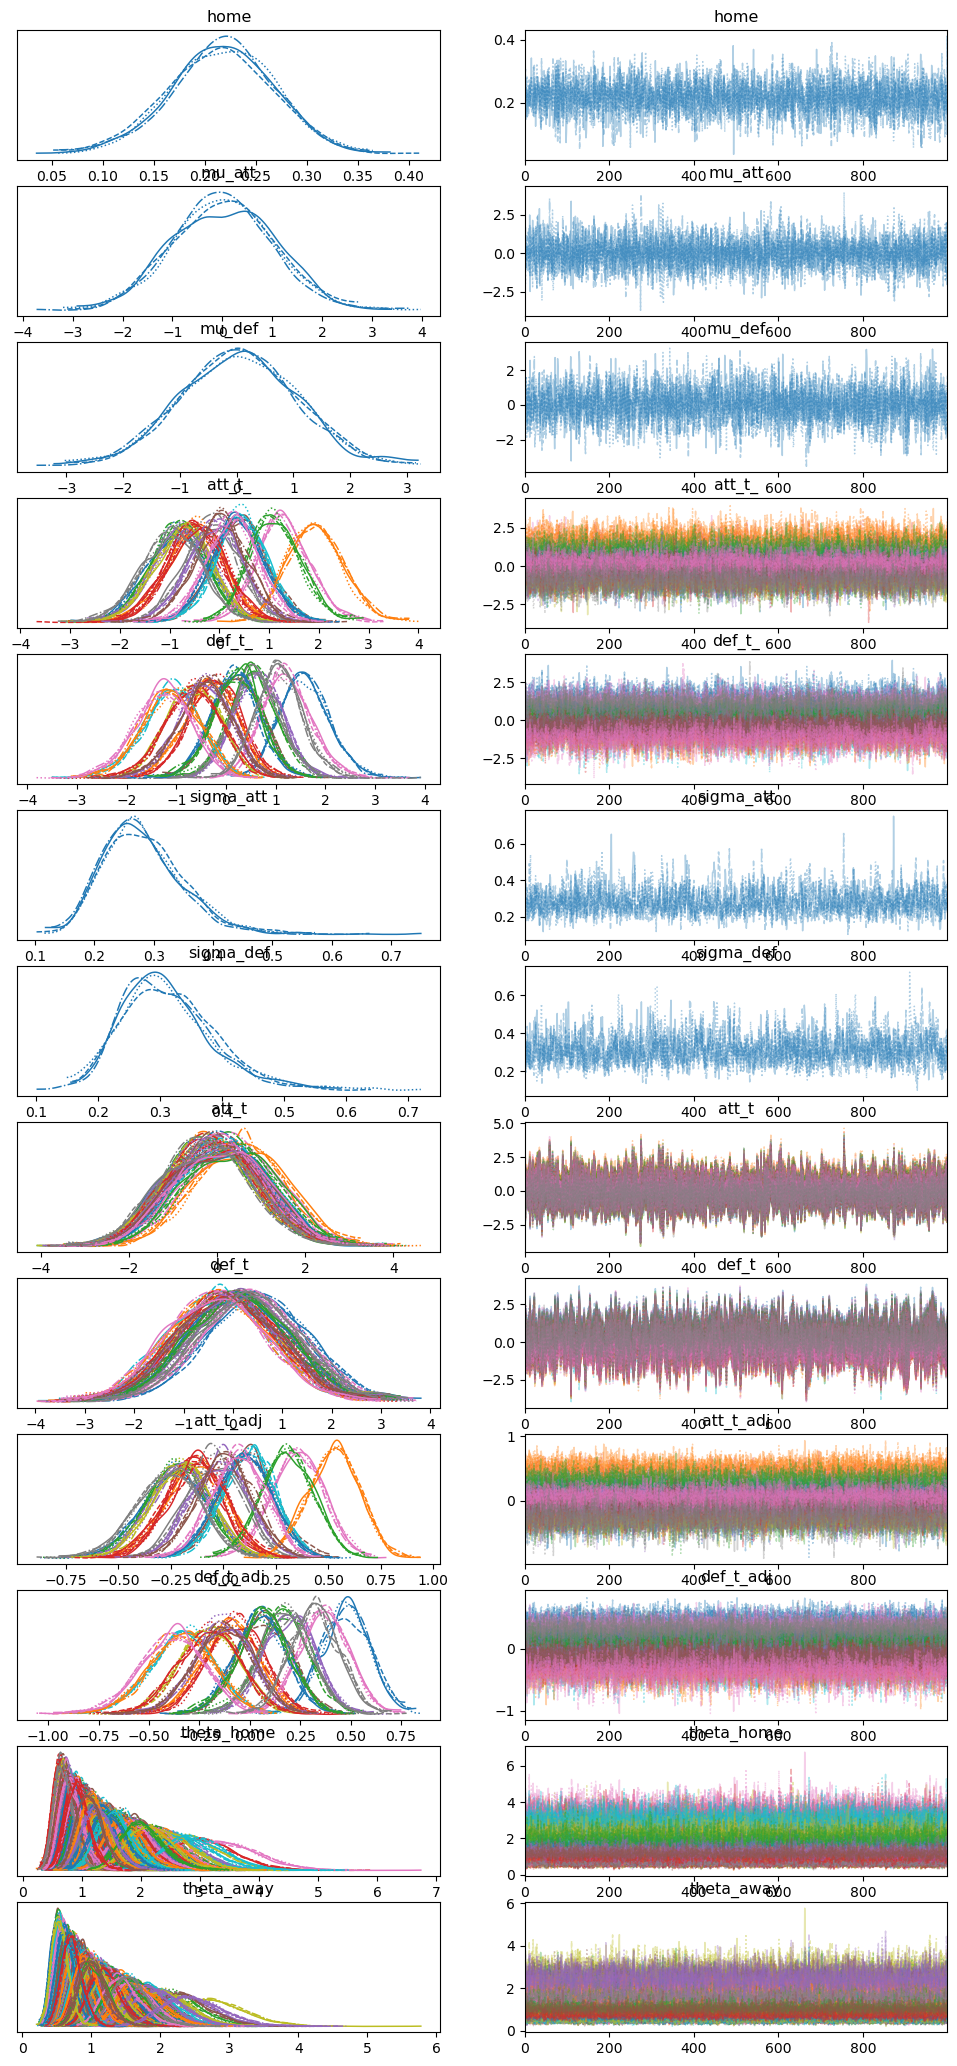

In [43]:
az.plot_trace(idata);

# Model 4 Appraisal
+ Reproduction of original results
+ Calibration

In [44]:
summ_df = az.summary(idata, hdi_prob=0.95).round(2)
summ_df

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
home             0.22  0.05      0.11       0.32       0.00     0.00   
mu_att           0.02  1.01     -1.90       1.99       0.01     0.02   
mu_def           0.03  1.03     -2.01       1.98       0.02     0.02   
att_t_[0]       -0.84  0.61     -2.02       0.28       0.01     0.01   
att_t_[1]       -0.49  0.59     -1.66       0.67       0.01     0.01   
...               ...   ...       ...        ...        ...      ...   
theta_away[301]  0.94  0.19      0.60       1.32       0.00     0.00   
theta_away[302]  1.04  0.20      0.67       1.44       0.00     0.00   
theta_away[303]  0.73  0.15      0.44       1.01       0.00     0.00   
theta_away[304]  2.48  0.43      1.74       3.37       0.01     0.00   
theta_away[305]  1.04  0.20      0.68       1.44       0.00     0.00   

                 ess_bulk  ess_tail  r_hat  
home               4289.0    2983.0    1.0  
mu_att             5276.0    2908.0    1.0  
mu_def             4016.0    3208.0    1.0  
att_t_[0]          3248.0    2919.0    1.0  
att_t_[1]          3136.0    2735.0    1.0  
...                   ...       ...    ...  
theta_away[301]    5661.0    3095.0    1.0  
theta_away[302]    4802.0    2949.0    1.0  
theta_away[303]    5388.0    3126.0    1.0  
theta_away[304]    4775.0    3653.0    1.0  
theta_away[305]    5704.0    3043.0    1.0  

[725 rows x 9 columns]

In [45]:
att_rows = summ_df.filter(regex='att_t_adj', axis=0).index.tolist()
atts = summ_df.loc[['home'] + att_rows, ['mean', 'hdi_2.5%', 'hdi_97.5%']]
atts

mean  hdi_2.5%  hdi_97.5%
home           0.22      0.11       0.32
att_t_adj[0]  -0.23     -0.53       0.06
att_t_adj[1]  -0.13     -0.43       0.14
att_t_adj[2]  -0.23     -0.52       0.05
att_t_adj[3]  -0.15     -0.44       0.11
att_t_adj[4]  -0.20     -0.48       0.08
att_t_adj[5]   0.12     -0.13       0.38
att_t_adj[6]   0.35      0.10       0.60
att_t_adj[7]  -0.04     -0.30       0.22
att_t_adj[8]  -0.20     -0.48       0.08
att_t_adj[9]   0.12     -0.13       0.35
att_t_adj[10]  0.10     -0.16       0.35
att_t_adj[11]  0.53      0.29       0.75
att_t_adj[12]  0.30      0.08       0.56
att_t_adj[13] -0.12     -0.41       0.14
att_t_adj[14] -0.02     -0.27       0.26
att_t_adj[15]  0.00     -0.26       0.26
att_t_adj[16]  0.07     -0.17       0.32
att_t_adj[17] -0.27     -0.56       0.04

In [46]:
theta_home_mean_ser = summ_df.filter(regex='theta_home', axis=0)['mean'].rename('theta_home_mean').reset_index(drop=True)
theta_away_mean_ser = summ_df.filter(regex='theta_away', axis=0)['mean'].rename('theta_away_mean').reset_index(drop=True)
df_res = pd.concat([df, theta_home_mean_ser, theta_away_mean_ser], axis=1)
df_res

g      home        away  hg  ag  yg1  yg2 result  theta_home_mean  \
0      0    Verona        Roma  17  14  0.0  1.0   awin             0.86   
1      1    Napoli    Atalanta  12   1  1.0  0.0   hwin             1.56   
2      2     Lazio       Parma  10  13  1.0  1.0   draw             1.14   
3      3  Juventus  Fiorentina   9   5  1.0  0.0   hwin             1.53   
4      4     Inter      Foggia   8   6  1.0  1.0   draw             1.49   
..   ...       ...         ...  ..  ..  ...  ...    ...              ...   
301  301     Parma  Fiorentina  13   5  1.0  1.0   draw             1.21   
302  302    Napoli       Genoa  12   7  1.0  0.0   hwin             2.04   
303  303     Inter    Atalanta   8   1  0.0  0.0   draw             0.94   
304  304    Foggia       Milan   6  11  2.0  8.0   awin             1.28   
305  305  Cagliari       Lazio   3  10  0.0  1.0   awin             1.15   

     theta_away_mean  
0               1.38  
1               0.95  
2               0.95  
3               0.82  
4               1.18  
..               ...  
301             0.94  
302             1.04  
303             0.73  
304             2.48  
305             1.04  

[306 rows x 10 columns]

In [47]:
# TODO - Remove and use distributions from model
# https://pena.lt/y/2021/08/25/predicting-football-results-using-bayesian-statistics-with-python-and-pymc3/
def win_draw_loss(home_expectation, away_expectation, max_goals=10):
    h = poisson.pmf(range(max_goals+1), home_expectation)
    a = poisson.pmf(range(max_goals+1), away_expectation)    
    m = np.outer(h, a)

    home = np.sum(np.tril(m, -1))
    away = np.sum(np.triu(m, 1))
    draw = np.sum(np.diag(m))

    return home, draw, away

In [48]:
df_res[['p(hwinc)', 'p(drawc)', 'p(awinc)']] = df_res.apply(lambda x: win_draw_loss(x.theta_home_mean, x.theta_away_mean),
                                                         axis=1, result_type='expand')
df_res = pd.concat([df_res, pd.get_dummies(df_res['result'])], axis=1)
df_res

g      home        away  hg  ag  yg1  yg2 result  theta_home_mean  \
0      0    Verona        Roma  17  14  0.0  1.0   awin             0.86   
1      1    Napoli    Atalanta  12   1  1.0  0.0   hwin             1.56   
2      2     Lazio       Parma  10  13  1.0  1.0   draw             1.14   
3      3  Juventus  Fiorentina   9   5  1.0  0.0   hwin             1.53   
4      4     Inter      Foggia   8   6  1.0  1.0   draw             1.49   
..   ...       ...         ...  ..  ..  ...  ...    ...              ...   
301  301     Parma  Fiorentina  13   5  1.0  1.0   draw             1.21   
302  302    Napoli       Genoa  12   7  1.0  0.0   hwin             2.04   
303  303     Inter    Atalanta   8   1  0.0  0.0   draw             0.94   
304  304    Foggia       Milan   6  11  2.0  8.0   awin             1.28   
305  305  Cagliari       Lazio   3  10  0.0  1.0   awin             1.15   

     theta_away_mean  p(hwinc)  p(drawc)  p(awinc)   awin   draw   hwin  
0               1.38  0.233911  0.275618  0.490471   True  False  False  
1               0.95  0.515597  0.254401  0.230001  False  False   True  
2               0.95  0.399486  0.298581  0.301933  False   True  False  
3               0.82  0.540773  0.258211  0.201016  False  False   True  
4               1.18  0.443389  0.256220  0.300390  False   True  False  
..               ...       ...       ...       ...    ...    ...    ...  
301             0.94  0.422502  0.291762  0.285736  False   True  False  
302             1.04  0.604635  0.209138  0.186217  False  False   True  
303             0.73  0.388299  0.341346  0.270355  False   True  False  
304             2.48  0.182329  0.181216  0.636397   True  False  False  
305             1.04  0.381961  0.291527  0.326512   True  False  False  

[306 rows x 16 columns]

In [49]:
dfc = df_res.copy()
n_bins = 5
strategy='quantile'
n_matches = len(dfc)
cal_df = make_1x2_calib_data(dfc, n_bins=n_bins, strategy=strategy, error_bar_alpha=0.05)
cal_df.head()

bin_num  mean_predicted_proba  mean_actual_proba  bin_count  prob_pred  \
0        0              0.222801           0.129032         62   0.222801   
1        1              0.335644           0.311475         61   0.335644   
2        2              0.415669           0.311475         61   0.415669   
3        3              0.503265           0.540984         61   0.503265   
4        4              0.655951           0.803279         61   0.655951   

   bin_count   2.5%_CI  97.5%_CI calib  
0         62  0.119221  0.326381  hwin  
1         61  0.217143  0.454146  hwin  
2         61  0.291993  0.539346  hwin  
3         61  0.377794  0.628736  hwin  
4         61  0.536736  0.775165  hwin

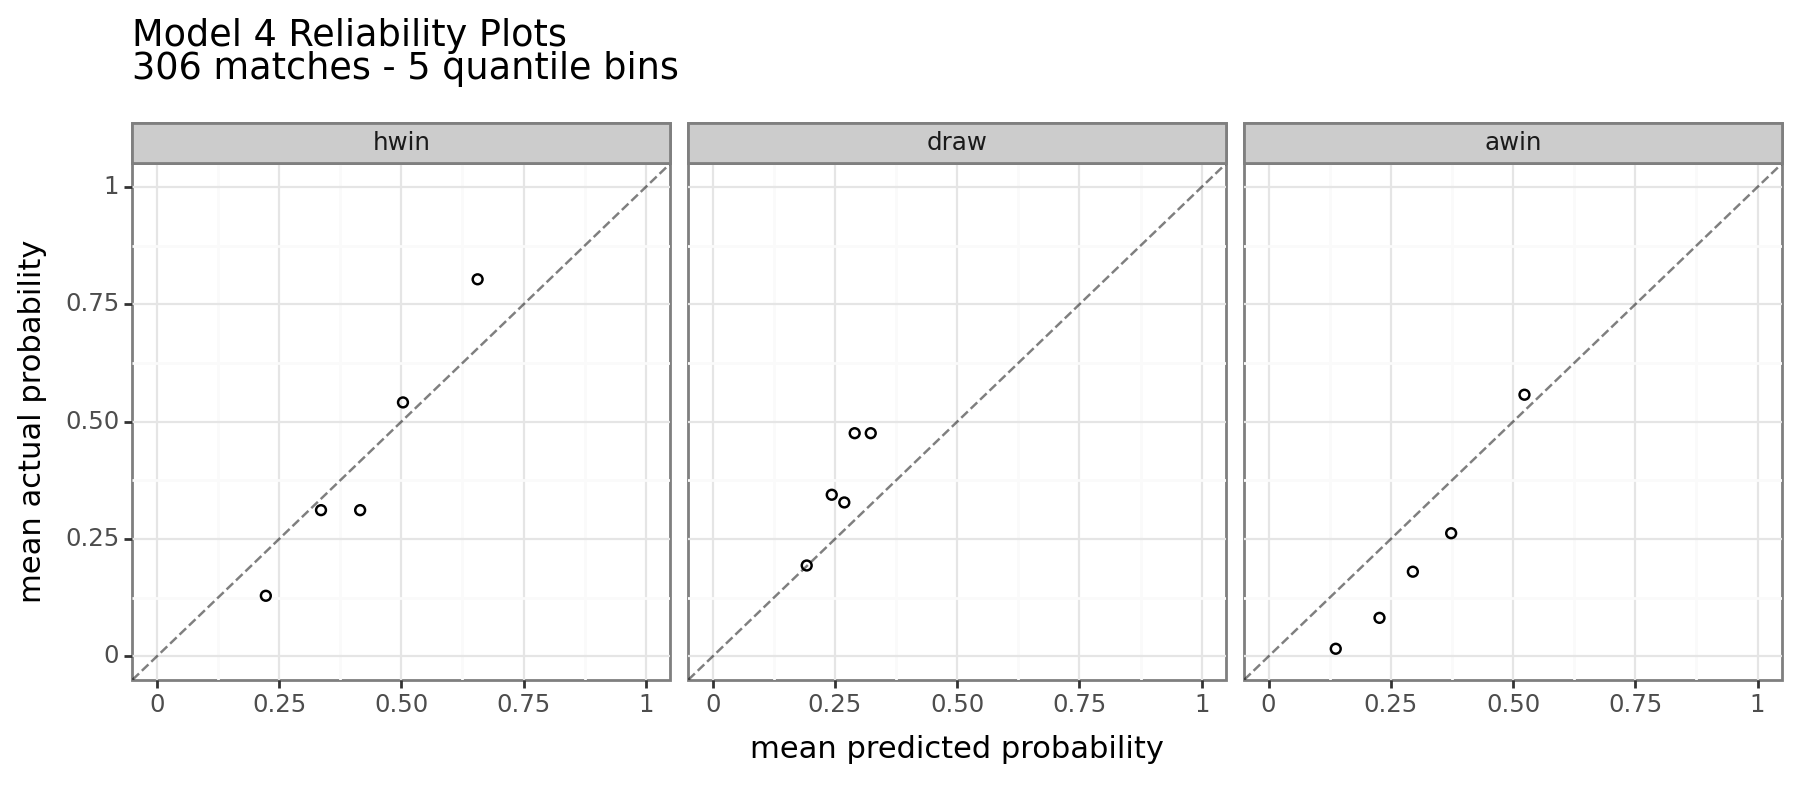

In [50]:
p = (ggplot(cal_df, aes(x='mean_predicted_proba', y='mean_actual_proba', group='calib')) +
     geom_point(fill='none') +
     # geom_errorbarh(aes(xmin='2.5%_CI', xmax='97.5%_CI'), height=0.025, alpha=0.3) +
     geom_abline(intercept=0, slope=1, alpha=0.5, linetype='dashed') +
     coord_cartesian(xlim=(0, 1.0), ylim=(0, 1.0)) +
     labs(x='mean predicted probability',
          y='mean actual probability',
          title=f'Model 4 Reliability Plots\n{n_matches} matches - {n_bins} {strategy} bins') +
     facet_wrap('calib') +
     theme(figure_size=(9,4))
    )
plt.close()
p.draw()

Changes to make a hierarchical model non-centred

with pm.Model() as hierarchical_model_non_centered:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Before:
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Transformed:
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)

    # Before:
    # b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)
    # Now:
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)


# Resources
+ [Predicting Football Results With Statistical Modelling (webpage) - David Sheehan](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)
+ [Bayesian hierarchical model for the prediction of football results (pdf) - Gianluca Baio1 & Marta A. Blangiardo 2010](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf)
+ [Analysis of sports data by using bivariate
Poisson models (pdf) - Dimitris Karlis & Ioannis Ntzoufras](http://www2.stat-athens.aueb.gr/~jbn/papers2/08_Karlis_Ntzoufras_2003_RSSD.pdf)
+ [Predicting Football Results Using Bayesian Modelling with Python and PyMC3 (webpage) -  Martin Eastwood - pena.lt/y blog](https://pena.lt/y/2021/08/25/predicting-football-results-using-bayesian-statistics-with-python-and-pymc3/)
+ [Hierarchical Modelling in Stan: Predicting the Premier League (YouTube video & associated material) -  Maggie Lieu - Stan Youtube channel](https://www.youtube.com/watch?v=dNZQrcAjgXQ&list=PLdw9iy95A5dh9tr3ZEiPICRYu8geqi9N9&index=103)
+ [Why hierarchical models are awesome, tricky, and Bayesian (webpage) - Thomas Wiecki - twiecki.io website](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/)
+ [Diagnosing Biased Inference with Divergences (webpage) - pymc documentation](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html)
+ [Bayesian-Hierarchical-Model-for-the-Prediction-of-Soccer-Results (github repository) - liotti2085 - github](https://github.com/liotti2085/Bayesian-Hierarchical-Model-for-the-Prediction-of-Soccer-Results/tree/main)
+ Data Sources
    + [Italy Serie A 1992-1993](https://fbref.com/en/comps/11/1992-1993/schedule/1992-1993-Serie-A-Scores-and-Fixtures) from fbref.com
    + [Italy Serie A 2007-2008](https://www.football-data.co.uk/italym.php) from football-data.co.uk
    + [Fixture Download website](https://fixturedownload.com/) includes future fixtures

## Original winBUGS code
```
model {
# LIKELIHOOD AND RANDOM EFFECT MODEL FOR THE SCORING PROPENSITY
for (g in 1:ngames) {
# Observed number of goals scored by each team
y1[g] ~ dpois(theta[g,1])
y2[g] ~ dpois(theta[g,2])
# Predictive distribution for the number of goals scored
ynew[g,1] ~ dpois(theta[g,1])
ynew[g,2] ~ dpois(theta[g,2])
# Average Scoring intensities (accounting for mixing components)
log(theta[g,1]) <- home + att[hometeam[g]] + def[awayteam[g]]
log(theta[g,2]) <- att[awayteam[g]] + def[hometeam[g]]
}
# 1. BASIC MODEL FOR THE HYPERPARAMETERS
# prior on the home effect
home ~ dnorm(0,0.0001)
# Trick to code the ‘‘sum-to-zero’’ constraint
for (t in 1:nteams){
att.star[t] ~ dnorm(mu.att,tau.att)
def.star[t] ~ dnorm(mu.def,tau.def)
att[t] <- att.star[t] - mean(att.star[])
def[t] <- def.star[t] - mean(def.star[])
}
# priors on the random effects
mu.att ~ dnorm(0,0.0001)
mu.def ~ dnorm(0,0.0001)
tau.att ~ dgamma(.01,.01)
tau.def ~ dgamma(.01,.01)
# 2. MIXTURE MODEL FOR THE HYPERPARAMETERS
# prior on the home effect
home ~ dnorm(0,0.0001)
# Mixture parameters & components (‘‘sum-to-zero’’ constraint)
for (t in 1:nteams){
grp.att[t] ~ dcat(p.att[t,])
grp.def[t] ~ dcat(p.def[t,])
att[t] ~ dt(mu.att[grp.att[t]],tau.att[grp.att[t]],4)
def[t] ~ dt(mu.def[grp.def[t]],tau.def[grp.def[t]],4)
att.star[t] <- att[t] - mean(att[])
def.star[t] <- def[t] - mean(def[])
# Priors on the mixture parameter (team specific)
p.att[t,1:3] ~ ddirch(prior.att[t,])
p.def[t,1:3] ~ ddirch(prior.def[t,])
}
# Priors on the random effects
# group 1: bottom-table teams
mu.att[1] ~ djl.dnorm.trunc(0,0.001,-3,0)
mu.def[1] ~ djl.dnorm.trunc(0,0.001,0,3)
tau.att[1] ~ dgamma(0.01,0.01)
tau.def[1] ~ dgamma(0.01,0.01)
# group 2: mid-table teams
mu.att[2] <-0
mu.def[2] <-0
tau.att[2] ~ dgamma(0.01,0.01)
tau.def[2] ~ dgamma(0.01,0.01)
# group 3: top-table teams
mu.att[3] ~ djl.dnorm.trunc(0,0.001,0,3)
mu.def[3] ~ djl.dnorm.trunc(0,0.001,-3,0)
tau.att[3] ~ dgamma(0.01,0.01)
tau.def[3] ~ dgamma(0.01,0.01)
}
```